#  Script for mouse position tracking in virtual visual test

In [1]:
import cv2
import numpy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

C:\Users\herdi\AppData\Local\Temp\ipykernel_8232\4201520216.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
#Functions
def animaltracking(path):
    print("Chose with the rectangle the animal you want to track and press 'enter'.The animal will be tracked until the video ends or until you press 'q'")
    print("REMEMBER TO ADAPT THE DIMENSION OF THE PLATFORM TO THE LIMITS OF EACH VIDEO AS CLOSE AS POSSIBLE FOR A BETTER REPRESENTATION OF THE TRACKING AND REPRODUCIBILITY OF DATA.")

    #Chose tracking method
    tracker = cv2.TrackerCSRT_create()
    tracker_name = 'CSRT tracker'

    #Capture video
    cap = cv2.VideoCapture(path)

    #Read the first frame
    ret, frame = cap.read()

    #Tracking
    roi = cv2.selectROI(frame, False)

    #Initialize tracker
    ret = tracker.init(frame, roi)

    result = []

    while cap.isOpened():
        #Read the first frame
        ret, frame = cap.read()

        #Update tracker
        success, roi = tracker.update(frame)

        (x,y,w,h) = tuple(map(int, roi))

        if success:
            pt1 = (x,y)
            pt2 = (x+w,y+h)
            cv2.rectangle(frame, pt1, pt2, (255,125,25), 3)

        else:
            cv2.putText(frame, "Fail", (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),3)

        if ret == False:
            break

        cv2.putText(frame,tracker_name, (20,400), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0), 3)

        #Display result
        cv2.imshow(tracker_name,frame)
        #result
        result.append((x,y))

        if cv2.waitKey(1) & 0xFF == 113:
            break

    cap.release()
    cv2.destroyAllWindows()

    return result

def shallowsidetime(lst, videowidth, videoheight, platformwidth, platformheight):
    X = [0,videowidth]
    Y = [0,videoheight]
    data = {}

    for (x,y) in lst:
        X.append(x)
        Y.append(y)

    data = {'X': X, 'Y': Y}
    df = pd.DataFrame(data)

    #Adapt the video dimensions to the real platform dimensions
    df['Xcm'] = df['X']*platformwidth/X[1]
    df['Ycm'] = df['Y']*platformheight/Y[1]
    df['Ycm_inv'] = 0 + (platformheight - df['Ycm'])

    vector_x = df['Xcm'].values
    vector_y = df['Ycm_inv'].values
    df['vector_x'] = vector_x
    df['vector_y'] = vector_y

    #Clasification of the position in each side (shallow or deep)
    Xmitad = 45 * 0.5
    df['side'] = df.Xcm > Xmitad
    df['side'] = df.side.replace({True : "shallowside", False : "deepside"})

    #Calculate the fraction of time spend in each side
    shallowcounter = 0
    deepcounter = 0

    for position in df['side']:
        if position == 'deepside':
            deepcounter = deepcounter + 1
        if position == 'shallowside':
            shallowcounter = shallowcounter + 1

    deeptimeporcentage = (deepcounter/25)*100/28
    shallowtimeporcentage = (shallowcounter/25)*100/28
    dataplot = {'Deep side': [round(deeptimeporcentage,2)], 'Shallow side': [round(shallowtimeporcentage,2)]}
    dataplot
    dt = pd.DataFrame(dataplot)

    #plot result
    sns.barplot(data = dt)
    plt.ylabel("Fraction of time spend in the shallow side per animal")
    plt.title("Virtual visual cliff")
    plt.ylim(0,100)
    plot = plt.show()


    return df, dt, plot

def animaltrackingheatmap(x, y, sigma, bins, color, thres):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins = bins)
    heatmap = gaussian_filter(heatmap, sigma = sigma)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(figsize =(10,10))
    a = plt.imshow(heatmap.T, extent = extent, origin ='lower', cmap = color, vmin = 0, vmax = thres)

    plt.suptitle('Heatmap')
    plt.axvline(x = xedges[-1]/2, color = 'white')
    plt.title('Heatmap of tracked animal position')
    fig.colorbar(a)
    plot = plt.show()

    return plot

# Working section

In [3]:
videopath = "C:\\Users\\herdi\\Desktop\\SHAM + MET c marker.mp4"
result = animaltracking(videopath)

Chose with the rectangle the animal you want to track and press 'enter'.The animal will be tracked until the video ends or until you press 'q'
REMEMBER TO ADAPT THE DIMENSION OF THE PLATFORM TO THE LIMITS OF EACH VIDEO AS CLOSE AS POSSIBLE FOR A BETTER REPRESENTATION OF THE TRACKING AND REPRODUCIBILITY OF DATA.


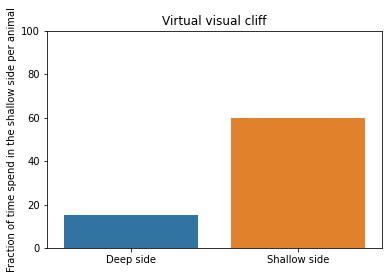

,Deep side,Shallow side
0,15.43,60.0


In [4]:
alldata, fractiontimes, plot = shallowsidetime(result, 1024, 576, 45, 30)
fractiontimes

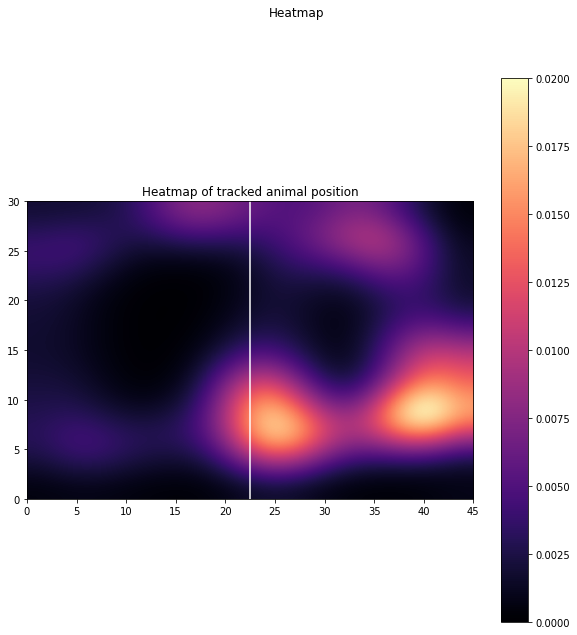

In [11]:
animaltrackingheatmap(alldata['vector_x'], alldata['vector_y'], 30, 350,'magma', 0.02)